In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1O0vmyRmcN0wT9FmIU7KkvFEK9FS36XdT'
link_id = link.split('=')[1]
download = drive.CreateFile({'id': link_id}) 
download.GetContentFile('/content/complete_dataset.csv')

In [4]:
import pandas as pd
df = pd.read_csv('/content/complete_dataset.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

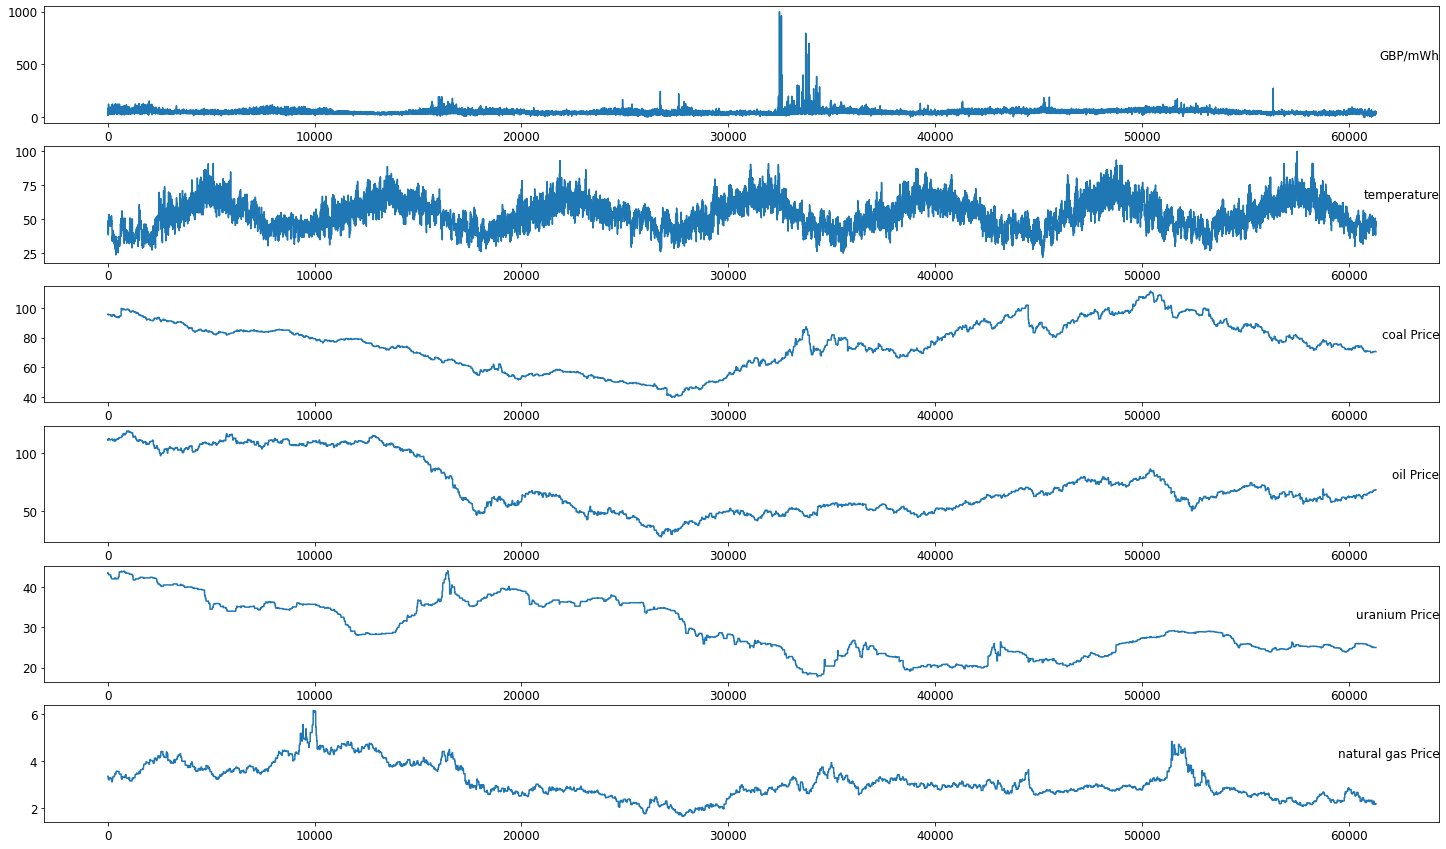

In [5]:
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [6]:
import seaborn as sns

### Our current shape is simply the shape of the dataframe : 61326 rows by 6 features

#### Because this is a time series analysis, we must make time a dimension. We want each window of time to include the past week of values, and look forward to the next 24 hours as this is what the model will do. For every row (or hour) we now have a window of 192 hours, and 6 features, giving us a shape (61134, 192, 6)

In [7]:
df.shape

(61326, 6)

In [8]:
n_steps = 168


In [9]:
n_steps = 168
data = df.values

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

In [11]:
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

In [12]:
series_reshaped.shape

(61134, 192, 6)

### Now that we have our data in this format, we need to split it so we have blocks of 168 hours (1 week) of every feature for the input data, and for every 168 block of hours, we have a 24 hour output, so our model can 'see' the next 24 hours

In [13]:
X_train = series_reshaped[:43800, :n_steps]
X_valid = series_reshaped[43800:52560, :n_steps]
X_test = series_reshaped[52560:, :n_steps]
Y = np.empty((61134, n_steps, 24))

for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:43800]
Y_valid = Y[43800:52560]
Y_test = Y[52560:]

In [14]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [15]:
es = EarlyStopping(monitor = 'val_loss')

Deep Multivariate Recurrant Neural Network

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 6]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
1369/1369 [==============================] - 89s 64ms/step - loss: 36.5757 - val_loss: 20.9758
Epoch 2/20
1369/1369 [==============================] - 87s 64ms/step - loss: 18.0161 - val_loss: 19.0851
Epoch 3/20
1369/1369 [==============================] - 86s 63ms/step - loss: 17.0702 - val_loss: 16.7358
Epoch 4/20
1369/1369 [==============================] - 86s 63ms/step - loss: 16.3422 - val_loss: 16.0356
Epoch 5/20
1369/1369 [==============================] - 87s 63ms/step - loss: 15.5406 - val_loss: 15.6493
Epoch 6/20
1369/1369 [==============================] - 86s 63ms/step - loss: 14.5703 - val_loss: 14.7050
Epoch 7/20
1369/1369 [==============================] - 85s 62ms/step - loss: 13.8447 - val_loss: 15.2774
Epoch 8/20
1369/1369 [==============================] - 85s 62ms/step - loss: 13.2989 - val_loss: 13.5728
Epoch 9/20
1369/1369 [==============================] - 86s 63ms/step - loss: 12.9403 - val_loss: 13.8216
Epoch 10/20
1369/1369 [=======================

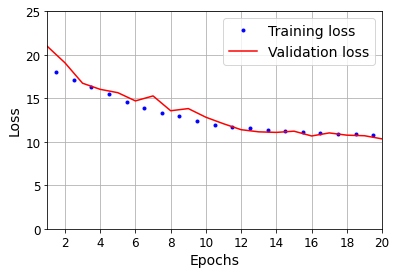

In [17]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [18]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [19]:
# from google.colab import files
# actual.to_csv('RNNresults.csv') 
# files.download('RNNresults.csv')

Simple Long-Short Term Memory Model

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 6]),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
1369/1369 [==============================] - 85s 61ms/step - loss: 23.7517 - val_loss: 17.5943
Epoch 2/20
1369/1369 [==============================] - 83s 61ms/step - loss: 15.8022 - val_loss: 17.2710
Epoch 3/20
1369/1369 [==============================] - 83s 61ms/step - loss: 14.4767 - val_loss: 13.8838
Epoch 4/20
1369/1369 [==============================] - 84s 61ms/step - loss: 13.6068 - val_loss: 12.5761
Epoch 5/20
1369/1369 [==============================] - 84s 61ms/step - loss: 12.7414 - val_loss: 11.9362
Epoch 6/20
1369/1369 [==============================] - 83s 61ms/step - loss: 12.5019 - val_loss: 12.4965
Epoch 7/20
1369/1369 [==============================] - 83s 61ms/step - loss: 12.3282 - val_loss: 12.2763
Epoch 8/20
1369/1369 [==============================] - 82s 60ms/step - loss: 12.0172 - val_loss: 11.7994
Epoch 9/20
1369/1369 [==============================] - 84s 61ms/step - loss: 11.7360 - val_loss: 11.1679
Epoch 10/20
1369/1369 [=======================

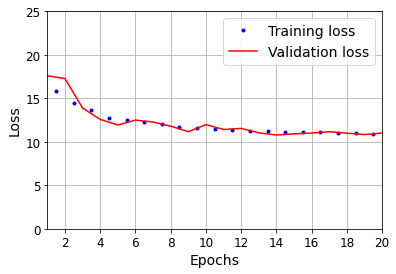

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [22]:
Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

Deep LSTM model

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(168,6)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")
history9 = model9.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es] )

Epoch 1/20
1369/1369 [==============================] - 354s 255ms/step - loss: 16.4488 - val_loss: 15.4355
Epoch 2/20
1369/1369 [==============================] - 347s 254ms/step - loss: 12.5874 - val_loss: 12.4985


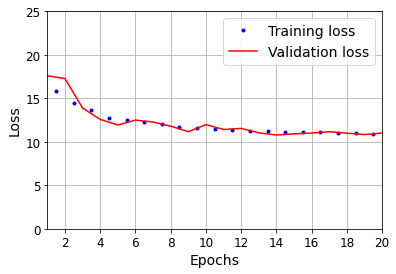

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [25]:
Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('deeplstmresults.csv') 
# files.download('deeplstmresults.csv')

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 6]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model10.compile(loss="mape", optimizer="adam")
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es])

Epoch 1/20
1369/1369 [==============================] - 125s 89ms/step - loss: 17.1872 - val_loss: 14.3266
Epoch 2/20
1369/1369 [==============================] - 120s 88ms/step - loss: 12.4350 - val_loss: 11.6256


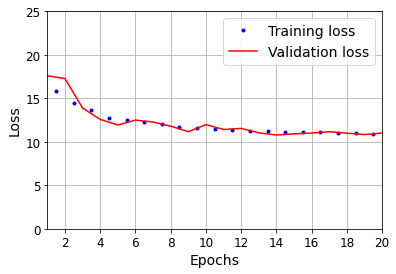

In [27]:

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [28]:
Y_pred = model10.predict(X_test)


In [29]:
Y_pred.shape

(8574, 83, 24)

In [30]:
Y_pred = model10.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][3::2][0][23]))
    

actual = pd.DataFrame(X_test[: , 0, 0])
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('convlayerresults.csv') 
# files.download('convlayerresults.csv')

ValueError: ignored

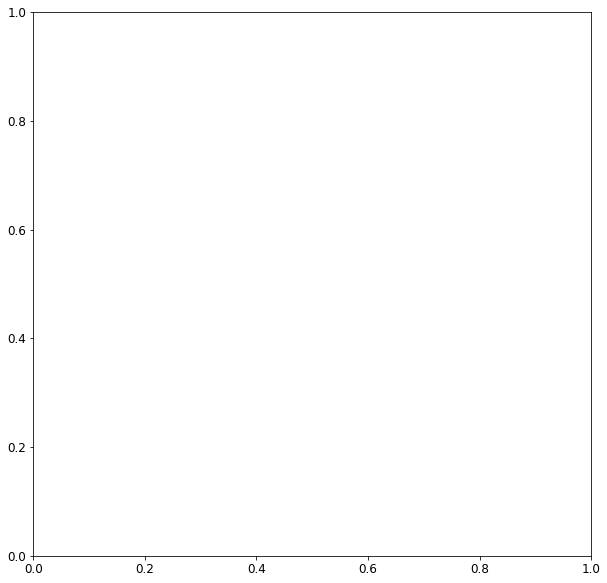

In [54]:
X_test =np.arange(0,len(X_test),1)
plt.figure(figsize=(10,10))
plt.scatter(X_test, Y_pred, color='red')
plt.plot(range(my_range), range(my_range), 'o')
plt.title(regressorName)
plt.show()


In [52]:
print((X_test))

[[[0.05673561 0.3600568  0.82016004 0.26719402 0.41714286 0.36895787]
  [0.06149685 0.3600568  0.82016004 0.26719402 0.41714286 0.36895787]
  [0.08168969 0.35966951 0.82016004 0.26719402 0.41714286 0.36895787]
  ...
  [0.06393236 0.34404854 0.78548364 0.32058888 0.42095238 0.31152993]
  [0.06283438 0.36134779 0.78548364 0.32058888 0.42095238 0.31152993]
  [0.06046874 0.36625355 0.78548364 0.32058888 0.42095238 0.31152993]]

 [[0.06149685 0.3600568  0.82016004 0.26719402 0.41714286 0.36895787]
  [0.08168969 0.35966951 0.82016004 0.26719402 0.41714286 0.36895787]
  [0.09266949 0.35954041 0.82016004 0.26719402 0.41714286 0.36895787]
  ...
  [0.06283438 0.36134779 0.78548364 0.32058888 0.42095238 0.31152993]
  [0.06046874 0.36625355 0.78548364 0.32058888 0.42095238 0.31152993]
  [0.05750419 0.36715724 0.78548364 0.32058888 0.42095238 0.31152993]]

 [[0.08168969 0.35966951 0.82016004 0.26719402 0.41714286 0.36895787]
  [0.09266949 0.35954041 0.82016004 0.26719402 0.41714286 0.36895787]
  [0

In [51]:
print(Y_pred)

[[[0.07857574 0.06380372 0.05891765 ... 0.05890023 0.05786668 0.07399676]
  [0.05547476 0.05114059 0.05145358 ... 0.07925407 0.06555622 0.0597847 ]
  [0.04835408 0.05069849 0.05522481 ... 0.06426082 0.05199077 0.04892109]
  ...
  [0.06499093 0.06070089 0.06401642 ... 0.0610603  0.06255835 0.06325661]
  [0.06187741 0.06155188 0.06678512 ... 0.06368923 0.06077253 0.05977987]
  [0.06101089 0.06320566 0.06901772 ... 0.05990303 0.05621604 0.05674441]]

 [[0.07601821 0.06115197 0.05848137 ... 0.06363264 0.06041645 0.07279809]
  [0.05071342 0.04871606 0.05212489 ... 0.07533407 0.06014019 0.05342359]
  [0.04559774 0.04860041 0.05366822 ... 0.05609751 0.04622322 0.04562022]
  ...
  [0.06342021 0.06057983 0.06521948 ... 0.06368495 0.0628042  0.06203213]
  [0.06132142 0.06264193 0.06843063 ... 0.06209826 0.05801427 0.05813749]
  [0.06037297 0.06271541 0.06882959 ... 0.05800366 0.05448312 0.0552703 ]]

 [[0.06593648 0.05429862 0.05735528 ... 0.06561942 0.05791643 0.06335124]
  [0.04819044 0.047227